In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from astropy.io import fits

In [3]:
def mad(x, axis=None):
    return np.nanmedian(np.abs(x - np.nanmedian(x, axis)), axis)

In [4]:
fnames = glob.glob('/data2/GBT/*/OnOff/*03_*/*B*.fits')
fnames.sort()
print len(fnames)

2


In [5]:
fnames

['/data2/GBT/3C295/OnOff/scan_03_006.raw.vegas/scan_03_006.raw.vegas.B.fits',
 '/data2/GBT/3C295/OnOff/scan_03_007.raw.vegas/scan_03_007.raw.vegas.B.fits']

In [24]:
f = fits.open(fnames[1])
hdu = f[1]
data = hdu.data['DATA']
N = 2**14
df = hdu.data['CDELT1'][0]
center_freq = hdu.data['CRVAL1'][0]
centerbin = hdu.data['CRPIX1'][0]
index = np.arange(N)
if_freqs = freqstest = index * (-df) # in Hz
mask = np.ones(N, dtype=bool)
mask[(index % 512) == 0] = False
mask[if_freqs < 150.e6] = False
mask[if_freqs > 1400.e6] = False
freqs = (center_freq + df * (index + 1 - centerbin))[::-1]
#mask[(freqs >= 4.225e9) & (freqs <= 4.375e9)] = False

In [25]:
xxoff = data[::8, ::-1]
xxoff = xxoff[200:, mask]
msdata = xxoff - np.nanmean(xxoff, 0)

In [26]:
ratio = np.nanstd(xxoff, 0) / np.nanmean(xxoff, 0)
bad = np.abs(ratio - np.median(ratio)) > 5. / 0.67449 * mad(ratio)
mask[mask] = ~bad

In [27]:
xxoff = data[::8, ::-1]
xxoff = xxoff[200:, mask]
msdata = xxoff - np.nanmean(xxoff, 0)

In [23]:
def S295(freqs):
    a0 = 1.4866 
    a1 = -0.7871
    a2 = -0.3440
    a3 = 0.0749
    f = freqs * 1.e-9
    logf = np.log10(f)
    logS = a0 + a1*logf + a2*logf**2 + a3*logf**3
    return 10.**(logS)

In [39]:
def get_freqs_pdiode():
    f = fits.open(fnames[0])
    hdu = f[1]
    data = hdu.data['DATA']
    N = 2**14
    df = hdu.data['CDELT1'][0]
    center_freq = hdu.data['CRVAL1'][0]
    centerbin = hdu.data['CRPIX1'][0]
    index = np.arange(N)
    if_freqs = freqstest = index * (-df) # in Hz
    mask = np.ones(N, dtype=bool)
    mask[(index % 512) == 0] = False
    mask[if_freqs < 150.e6] = False
    mask[if_freqs > 1400.e6] = False
    freqs = (center_freq + df * (index + 1 - centerbin))[::-1]
    # for bank A
    #mask[(freqs >= 4.225e9) & (freqs <= 4.375e9)] = False
    
    #for bank B
    xxoff = data[::8, ::-1]
    onSoffD = xxoff[200:, mask]
    ratio = np.nanstd(onSoffD, 0) / np.nanmean(onSoffD, 0)
    bad = np.abs(ratio - np.median(ratio)) > 5. / 0.67449 * mad(ratio)
    mask[mask] = ~bad
    xxoff = data[::8, ::-1]
    onSoffD = xxoff[200:, mask]
    xxon = data[1::8, ::-1]
    onSonD = xxon[200:, mask]

    f = fits.open(fnames[1])
    hdu = f[1]
    data = hdu.data['DATA']
    N = 2**14
    df = hdu.data['CDELT1'][0]
    center_freq = hdu.data['CRVAL1'][0]
    centerbin = hdu.data['CRPIX1'][0]
    index = np.arange(N)
    if_freqs = freqstest = index * (-df) # in Hz
    mask = np.ones(N, dtype=bool)
    mask[(index % 512) == 0] = False
    mask[if_freqs < 150.e6] = False
    mask[if_freqs > 1400.e6] = False
    freqs = (center_freq + df * (index + 1 - centerbin))[::-1]
    
    #mask[(freqs >= 4.225e9) & (freqs <= 4.375e9)] = False
    
    #for bank B
    xxoff = data[::8, ::-1]
    offSoffD = xxoff[200:, mask]
    ratio = np.nanstd(offSoffD, 0) / np.nanmean(offSoffD, 0)
    bad = np.abs(ratio - np.median(ratio)) > 5. / 0.67449 * mad(ratio)
    mask[mask] = ~bad
    xxoff = data[::8, ::-1]
    offSoffD = xxoff[200:, mask]
    xxon = data[1::8, ::-1]
    offSonD = xxon[200:, mask]
  
    
    Psource = S295(freqs[mask])
    gain = np.nanmean(onSoffD - offSoffD, 0) / Psource
    Pdiode = np.nanmean(offSonD - offSoffD, 0) / gain
    if show:
        figure()
        plot(freqs[mask], np.nanmean(onSonD, 0), label='onSonD')
        plot(freqs[mask], np.nanmean(onSoffD, 0), label='onSoffD')
        plot(freqs[mask], np.nanmean(offSonD, 0), label='offSonD')
        plot(freqs[mask], np.nanmean(offSoffD, 0), label='offSoffD')
        legend()
        
        figure()
        plot(freqs[mask], Pdiode)
        xlabel('frequency')
        ylabel('Jy')
    return freqs, Pdiode

In [40]:
fdiode, pdiode = get_freqs_pdiode()

ValueError: operands could not be broadcast together with shapes (1231,13614) (1231,13617) 

In [72]:
#np.save('../calibrations/lownoise_calibration_3C295_03_Axx_big.npy', [fdiode, pdiode])

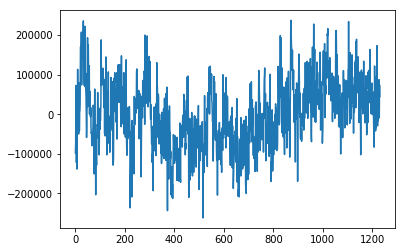

In [28]:
plot(msdata.mean(1))

In [29]:
ndata = xxoff / np.nanmedian(xxoff, 0)

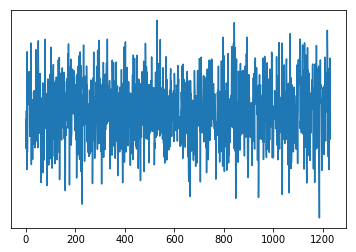

In [30]:
semilogy(ndata.std(1))

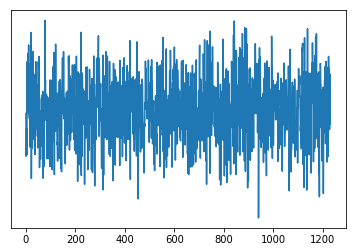

In [31]:
semilogy(msdata.std(1))

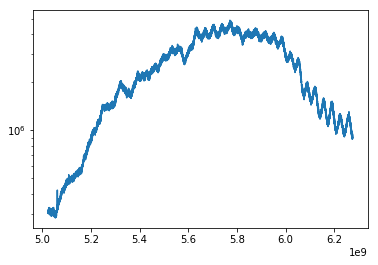

In [32]:
semilogy(freqs[mask], np.nanstd(msdata, 0))

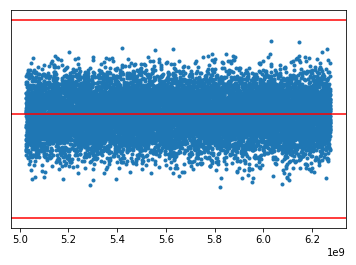

In [35]:
semilogy(freqs[mask], np.nanstd(xxoff, 0) / np.nanmean(xxoff, 0), '.')
axhline(np.median(np.nanstd(xxoff, 0) / np.nanmean(xxoff, 0)), color='r')
axhline(np.median(np.nanstd(xxoff, 0) / np.nanmean(xxoff, 0)) + 5. / 0.67449 * mad(np.nanstd(xxoff, 0) / np.nanmean(xxoff, 0)), color='r')
axhline(np.median(np.nanstd(xxoff, 0) / np.nanmean(xxoff, 0)) - 5. / 0.67449 * mad(np.nanstd(xxoff, 0) / np.nanmean(xxoff, 0)), color='r')

In [36]:
speck = np.nanmean((msdata**4), 0) / np.nanmean((msdata**2), 0)**2

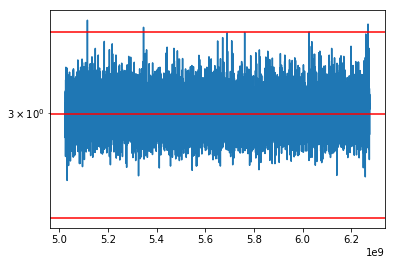

In [37]:
semilogy(freqs[mask], speck)
axhline(np.median(speck), color='r')
axhline(np.median(speck) + 5. / 0.67449 * mad(speck), color='r')
axhline(np.median(speck) - 5. / 0.67449 * mad(speck), color='r')

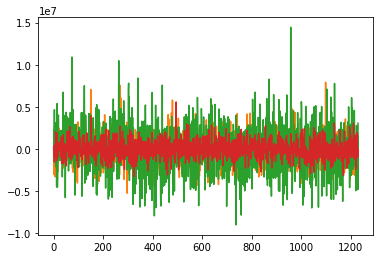

In [38]:
plot(msdata[:, np.abs(speck-np.median(speck)) > 5. / 0.67449 * mad(speck)]);